In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import statsmodels.formula.api as smf
from statsmodels.tools import add_constant

In [2]:
def compute_return(y, r_type="log", h=1):
    if r_type == "log":
        ret = (np.log(y) - np.log(y.shift(h))) * 100
    else:
        ret = ((y - y.shift(h)) / y.shift(h)) * 100
    return ret


NameError: name 'get_DAX' is not defined

In [3]:
import yfinance as yf

msft = yf.Ticker("^GDAXI")

In [4]:
hist = msft.history(period="max")

In [5]:
for i in range(5):
    hist["ret"+str(i+1)] = compute_return(hist["Close"], h=i+1)


In [6]:
hist.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ret1,ret2,ret3,ret4,ret5
Date,,,,,,,,,,,,
2023-11-09 00:00:00+01:00,15246.500000,15364.490234,15212.990234,15352.540039,68377100,0.0,0.0,0.804006,1.310618,1.420692,1.069299,1.370296
2023-11-10 00:00:00+01:00,15296.580078,15309.519531,15171.580078,15234.389648,77014100,0.0,0.0,-0.772559,0.031447,0.538060,0.648134,0.296741
2023-11-13 00:00:00+01:00,15285.120117,15346.790039,15252.269531,15345.000000,65170400,0.0,0.0,0.723434,-0.049125,0.754881,1.261494,1.371568
2023-11-14 00:00:00+01:00,15358.589844,15632.440430,15337.599609,15614.429688,98894400,0.0,0.0,1.740578,2.464012,1.691453,2.495459,3.002072
2023-11-15 00:00:00+01:00,15631.669922,15759.839844,15628.190430,15748.169922,0,0.0,0.0,0.852870,2.593448,3.316881,2.544323,3.348329


In [7]:
# Create lagged returns as independent variables
for i in range(1, 6):
    hist[f'lag_ret{i}'] = hist['Close'].shift(i)

# Remove rows with NaN values that result from lagging
hist.dropna(inplace=True)

# Quantile levels
tau = [.025, .25, .5, .75, .975]

In [8]:
pred_quantile_regression = np.zeros((5, 5))

In [9]:
# Perform quantile regression for each horizon and quantile
for i in range(5):
    ret_str = f"ret{i+1}"
    y = hist[ret_str]  # Dependent variable
    X = hist[[f'lag_ret{j}' for j in range(1, 6)]]  # Independent variables
    X = add_constant(X)  # Adds a constant term to the predictors

    for j, q in enumerate(tau):
        # Fit the model for the q-th quantile
        mod = smf.quantreg(f'{ret_str} ~ lag_ret1 + lag_ret2 + lag_ret3 + lag_ret4 + lag_ret5', hist)
        res = mod.fit(q=q)
        
        # Predict the quantile for the last observation
        pred_quantile_regression[i, j] = res.predict(X.iloc[-1:])[0]

/var/folders/y3/h1kjcg6j0wj3crmk4m1ff0380000gn/T/ipykernel_90340/204857745.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_quantile_regression[i, j] = res.predict(X.iloc[-1:])[0]
/var/folders/y3/h1kjcg6j0wj3crmk4m1ff0380000gn/T/ipykernel_90340/204857745.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_quantile_regression[i, j] = res.predict(X.iloc[-1:])[0]
/var/folders/y3/h1kjcg6j0wj3crmk4m1ff0380000gn/T/ipykernel_90340/204857745.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with Data

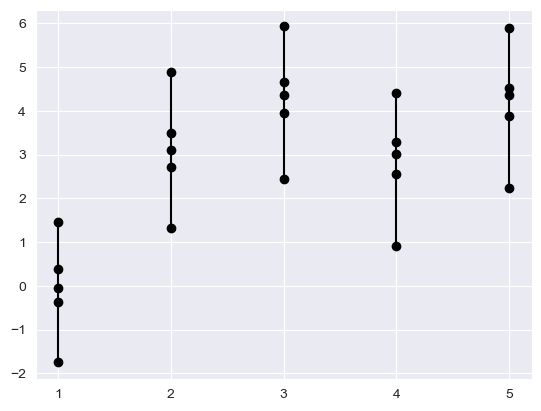

In [10]:
x = np.arange(5)+1
_ = plt.plot(x,pred_quantile_regression, ls="", marker="o", c="black")
_ = plt.xticks(x, x)
_ = plt.plot((x,x),(pred_quantile_regression[:,0], pred_quantile_regression[:,-1]),c='black')

In [11]:
from datetime import datetime, date
date_str = date.today() #.strftime('%Y%m%d')


In [12]:
df_sub = pd.DataFrame({
    "forecast_date": date_str,
    "target": "DAX",
    "horizon": [str(i) + " day" for i in (1, 2, 5, 6, 7)],
    "q0.025": pred_quantile_regression[:, 0],
    "q0.25": pred_quantile_regression[:, 1],
    "q0.5": pred_quantile_regression[:, 2],
    "q0.75": pred_quantile_regression[:, 3],
    "q0.975": pred_quantile_regression[:, 4]
})

In [13]:
df_sub

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975
0,2023-11-15,DAX,1 day,-1.752752,-0.377896,-0.056233,0.388798,1.457286
1,2023-11-15,DAX,2 day,1.323756,2.707983,3.099314,3.497059,4.887584
2,2023-11-15,DAX,5 day,2.448305,3.942753,4.370179,4.659071,5.926100
3,2023-11-15,DAX,6 day,0.901371,2.544323,3.017148,3.279382,4.402033
4,2023-11-15,DAX,7 day,2.225363,3.874377,4.350506,4.525232,5.882428


In [14]:
#need to change this
PATH = "../forecasts"
date_str = datetime.today().strftime('%Y%m%d')
df_sub.to_csv(PATH+"/"+date_str+"DAX_Quantile_Regression.csv",index=False)